In [65]:
import numpy as np
import matplotlib.pyplot as plt

from epymorph.kit import *
from epymorph.adrio import acs5
from epymorph.initializer import RandomLocationsAndRandomSeed

from epymorph.adrio import us_tiger

from epymorph.forecasting.pipeline import (
    FromRUME,
    ParticleFilterSimulator,
    Observations,
    ModelLink,
    UnknownParam
)

from epymorph.forecasting.likelihood import Poisson,NegativeBinomial
from epymorph.forecasting.dynamic_params import BrownianMotion,OrnsteinUhlenbeck
from epymorph.forecasting.dynamic_params import GaussianPrior
from epymorph.forecasting.param_transformations import ExponentialTransform

from epymorph.time import EveryNDays

In [66]:
states = ["AZ", "CO", "NM", "UT"]
rume = SingleStrataRUME.build(
    ipm=ipm.SIRH(),
    mm=mm.No(),
    scope=StateScope.in_states(states, year=2015),
    init=RandomLocationsAndRandomSeed(
        num_locations=len(states),
        seed_max=10_000
    ),
    time_frame=TimeFrame.of("2022-09-15", 7 * 26 + 1),
    params={
        "beta": ExponentialTransform('log_beta'),
        "gamma": 0.2,
        "xi": 1 / 365,
        "hospitalization_prob": 200 / 100_000,
        "hospitalization_duration": 5.0,
        "population": acs5.Population(),
        "phi":10,
        "commuter_proportion":0.30,
        "centroid": us_tiger.InternalPoint(),
    },
)

<Axes: xlabel='date', ylabel='value'>

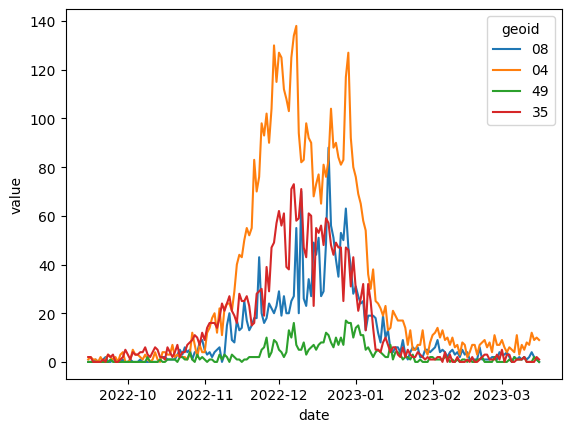

In [67]:
import seaborn as sns
import pandas as pd

columns = ['date','state','previous_day_admission_influenza_confirmed']

df = pd.read_csv('pf_vignettes/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries__RAW_.csv')

df = df[df['state'].isin(states)][columns]
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values('date')
df = df.reset_index(drop = True)

date_range = rume.time_frame.to_date_range().to_pandas()
df = df[df['date'].isin(date_range)][columns]
df.columns = ['date','geoid','value']

state_mapping = {state:id for state,id in zip(states,rume.scope.node_ids)}
df['geoid'] = df['geoid'].map(state_mapping)

df.to_csv(f'./pf_vignettes/daily_data_SW.csv',index = False)

sns.lineplot(data=df,x='date',y='value',hue='geoid')

In [68]:
from epymorph.adrio import csv

csvadrio = csv.CSVFileAxN(
    file_path='pf_vignettes/daily_data_SW.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [69]:


observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        quantity=rume.ipm.select.events("I->H"),
        time=rume.time_frame.select.all().group(EveryNDays(1)).agg(),
        geo=rume.scope.select.all(),
    ),
    likelihood=NegativeBinomial(r=10),
)

In [70]:
num_realizations = 100

unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=1/35,
            mean=np.log(0.2),
            standard_deviation=0.5,
        ),
    )
}

particle_filter_simulator = ParticleFilterSimulator(
        config=FromRUME(rume,num_realizations,unknown_params = unknown_params),
        observations= observations,
        save_trajectories=True,
    )


In [71]:
rng = np.random.default_rng(0)
particle_filter_output = particle_filter_simulator.run(rng=rng)

Observation: 0, Label: 2022-09-15, Time Frame: 2022-09-15 (1D), 
Observation: 1, Label: 2022-09-16, Time Frame: 2022-09-16 (1D), 
Observation: 2, Label: 2022-09-17, Time Frame: 2022-09-17 (1D), 
Observation: 3, Label: 2022-09-18, Time Frame: 2022-09-18 (1D), 
Observation: 4, Label: 2022-09-19, Time Frame: 2022-09-19 (1D), 
Observation: 5, Label: 2022-09-20, Time Frame: 2022-09-20 (1D), 
Observation: 6, Label: 2022-09-21, Time Frame: 2022-09-21 (1D), 
Observation: 7, Label: 2022-09-22, Time Frame: 2022-09-22 (1D), 
Observation: 8, Label: 2022-09-23, Time Frame: 2022-09-23 (1D), 
Observation: 9, Label: 2022-09-24, Time Frame: 2022-09-24 (1D), 
Observation: 10, Label: 2022-09-25, Time Frame: 2022-09-25 (1D), 
Observation: 11, Label: 2022-09-26, Time Frame: 2022-09-26 (1D), 
Observation: 12, Label: 2022-09-27, Time Frame: 2022-09-27 (1D), 
Observation: 13, Label: 2022-09-28, Time Frame: 2022-09-28 (1D), 
Observation: 14, Label: 2022-09-29, Time Frame: 2022-09-29 (1D), 
Observation: 15, Lab

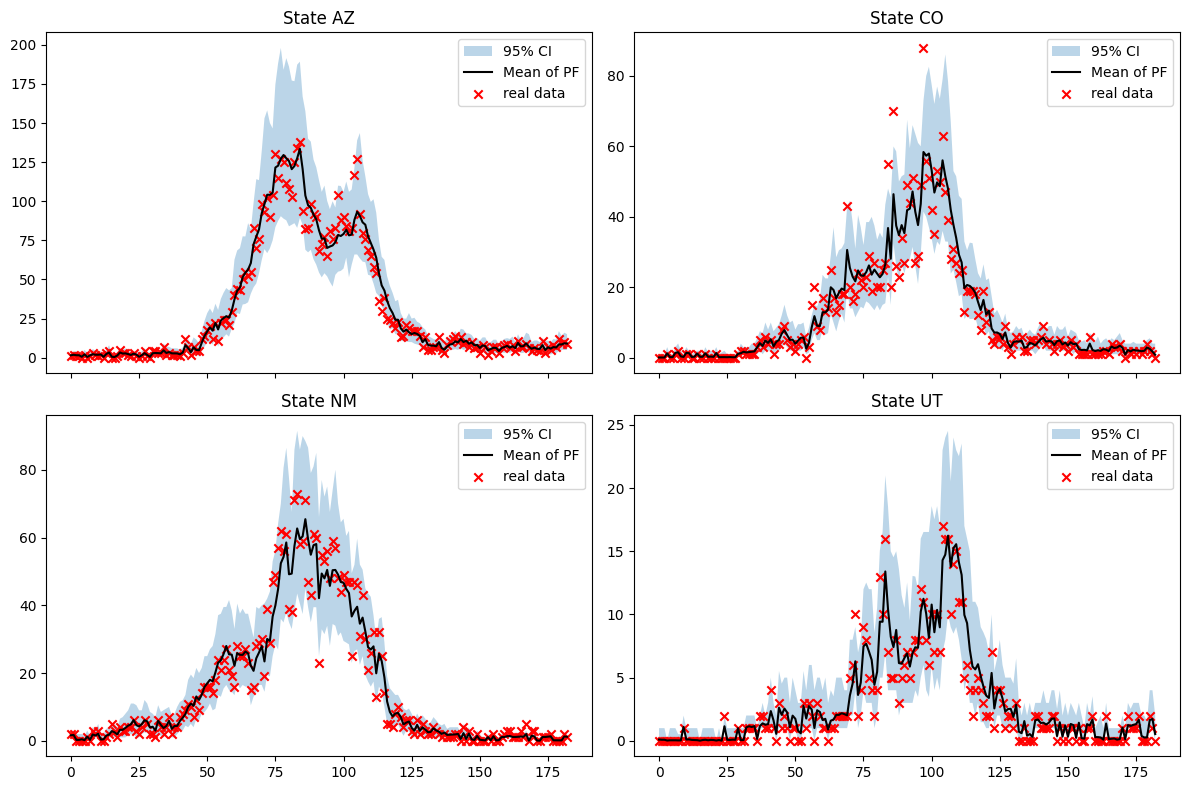

In [72]:
from epymorph.simulation import Context
from epymorph.attribute import NamePattern
from math import ceil

context = Context.of(
    scope=rume.scope,
    time_frame=rume.time_frame
)

real_data_result = (
    observations.source.with_context_internal(context).inspect().result
)
real_data = real_data_result["value"]

data_date_range = np.arange(0,rume.time_frame.days,1)
sim_date_range = np.arange(0,rume.time_frame.days,1)

n = len(states)
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()

for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower = np.percentile(particle_filter_output.posterior_values[:, :, i, :], 2.5, axis=1).squeeze()
    upper = np.percentile(particle_filter_output.posterior_values[:, :, i, :], 97.5, axis=1).squeeze()
    mean  = np.mean(particle_filter_output.posterior_values[:, :, i, :], axis=1).squeeze()

    ax.fill_between(data_date_range, lower, upper, alpha=0.3, label='95% CI')
    ax.plot(data_date_range, mean, color='black', label='Mean of PF')

    ax.scatter(data_date_range,real_data[:,i],marker = 'x',color = 'red',label = 'real data')
    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

fig.tight_layout()


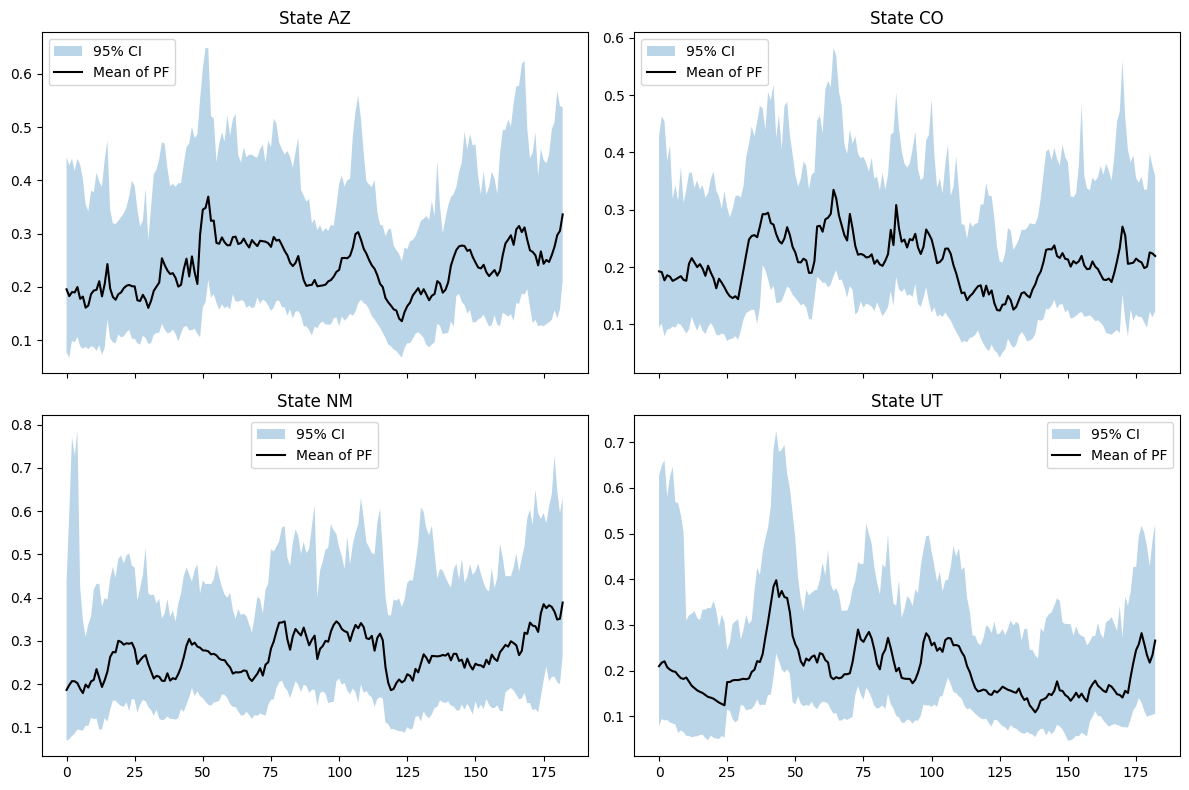

In [73]:
cols = 2
rows = ceil(n / cols)

fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 4*rows), sharex=True)
axes = axes.flatten()


for i in range(n):
    ax = axes[i]
    ax.set_title(f'State {states[i]}')

    lower = np.percentile(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 2.5, axis=0).squeeze()
    upper = np.percentile(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], 97.5, axis=0).squeeze()
    mean  = np.mean(particle_filter_output.estimated_params[NamePattern.of("log_beta")][:, :, i], axis=0).squeeze()

    ax.fill_between(sim_date_range, np.exp(lower), np.exp(upper), alpha=0.3, label='95% CI')
    ax.plot(sim_date_range, np.exp(mean), color='black', label='Mean of PF')
    ax.legend()

for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

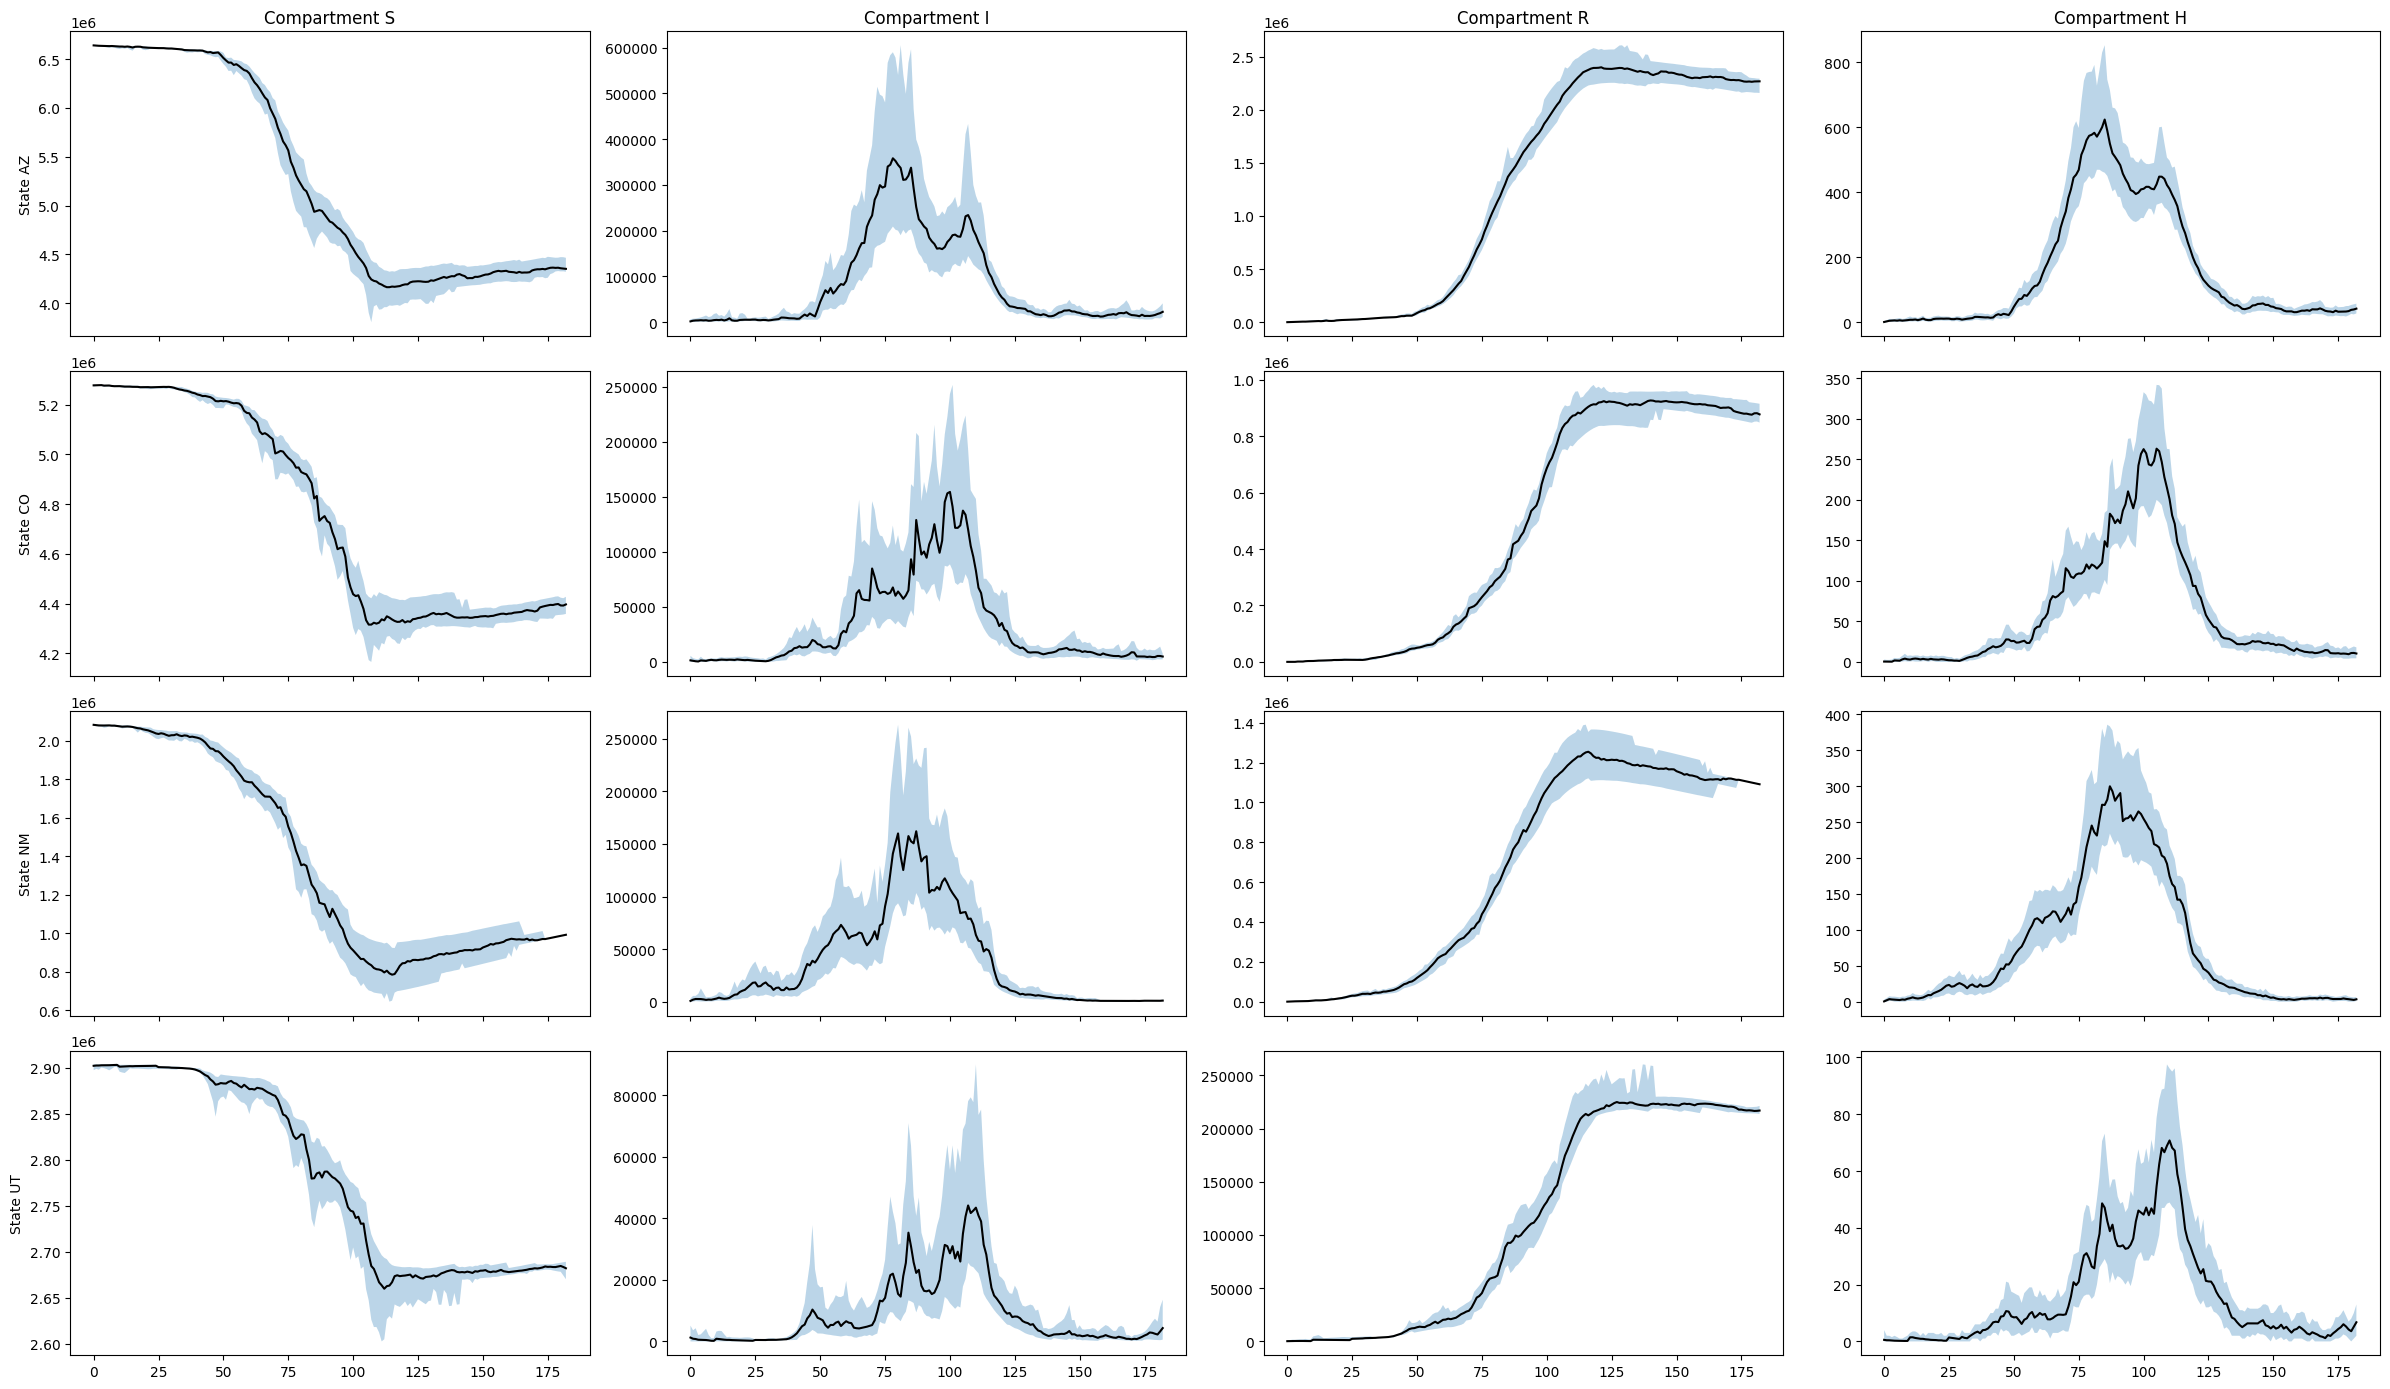

In [74]:
a = particle_filter_output.compartments.shape[3]   # = 4
compartment_labels = ['S','I','R','H']

rows = n                       # one row per state
cols = a                       # one column per last-axis element

fig, axes = plt.subplots(rows, cols,
                         figsize=(6*cols, 3.5*rows),
                         sharex=True)

# ensure axes is 2-D even if n or a = 1
axes = np.atleast_2d(axes)

for i in range(n):               # loop states
    for k in range(a):           # loop final-axis components
        ax = axes[i, k]

        data = particle_filter_output.compartments[:, :, i, k]

        lower = np.percentile(data, 2.5, axis=0).squeeze()
        upper = np.percentile(data, 97.5, axis=0).squeeze()
        mean  = np.mean(data, axis=0).squeeze()

        ax.fill_between(sim_date_range, lower, upper, alpha=0.3)
        ax.plot(sim_date_range, mean, color='black')

        # Titles by row / col for readability
        if i == 0:
            ax.set_title(f'Compartment {compartment_labels[k]}')
        if k == 0:
            ax.set_ylabel(f'State {states[i]}')

plt.tight_layout()
plt.show()
